In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **FORECAST**

## **Carga y limpieza de datos**

El objetivo de esta primera sección es cargar el dataset restaurants_visitors_limpio.csv, asegurarnos de que las fechas estén bien definidas y hacer limpieza de los datos 

In [184]:
# Importando df

df = pd.read_csv(r'/Users/adolfocruz/BC_Didi/BIChallenge/restaurants_visitors_limpio.csv')

In [185]:
# Se visualizan los datos
df.head()

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors
0,db80363d35f10926,2016-01-01,01/01/2016 00:00,01/01/2016 01:00,5
1,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 16:00,2
2,db80363d35f10926,2016-01-02,02/01/2016 01:00,01/01/2016 15:00,4
3,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 14:00,2
4,db80363d35f10926,2016-01-02,02/01/2016 18:00,02/01/2016 02:00,3


In [186]:
# Buscando datos faltantes

df.isnull().sum()

id                  0
visit_date          0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [187]:
# Revisando tipos de datos
df.dtypes

id                  object
visit_date          object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [188]:
# Transformando variable que estará en el index para predecir y otras columnas de fecha

df['visit_date'] = pd.to_datetime(df['visit_date'])
df['visit_datetime'] = pd.to_datetime(df['visit_date'])
df['reserve_datetime'] = pd.to_datetime(df['visit_date'])

In [189]:
# Viendo las descripciones básicas de los datos

df.describe().round(2)

,visit_date,visit_datetime,reserve_datetime,reserve_visitors
count,12162,12162,12162,12162.00
mean,2016-12-22 15:55:37.148495360,2016-12-22 15:55:37.148495360,2016-12-22 15:55:37.148495360,4.04
min,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,1.00
25%,2016-11-28 00:00:00,2016-11-28 00:00:00,2016-11-28 00:00:00,2.00
50%,2017-01-14 00:00:00,2017-01-14 00:00:00,2017-01-14 00:00:00,3.00
75%,2017-03-07 00:00:00,2017-03-07 00:00:00,2017-03-07 00:00:00,4.00
max,2017-05-31 00:00:00,2017-05-31 00:00:00,2017-05-31 00:00:00,56.00
std,NaN,NaN,NaN,4.14


### ***Exploración de los datos a través del tiempo (Mensual)***

Después de la limpieza y transformación de datos se trabajará en una primer propuesta, la que consiste en analizar la opción de hacer una agregación de frecuencia mensual para poder hacer el forecasting de los siguientes 6 meses.

In [190]:
# Haciendo la agregación para la predicción con frecuencia mensual

df_mes = df.groupby(pd.Grouper(key='visit_date', freq='MS'))['reserve_visitors'].sum().reset_index()

In [191]:
# Poniendo las fechas en el index

df_mes = df_mes.set_index('visit_date')
df_mes.head()

,reserve_visitors
visit_date,
2016-01-01,906
2016-02-01,868
2016-03-01,1307
2016-04-01,1340
2016-05-01,833


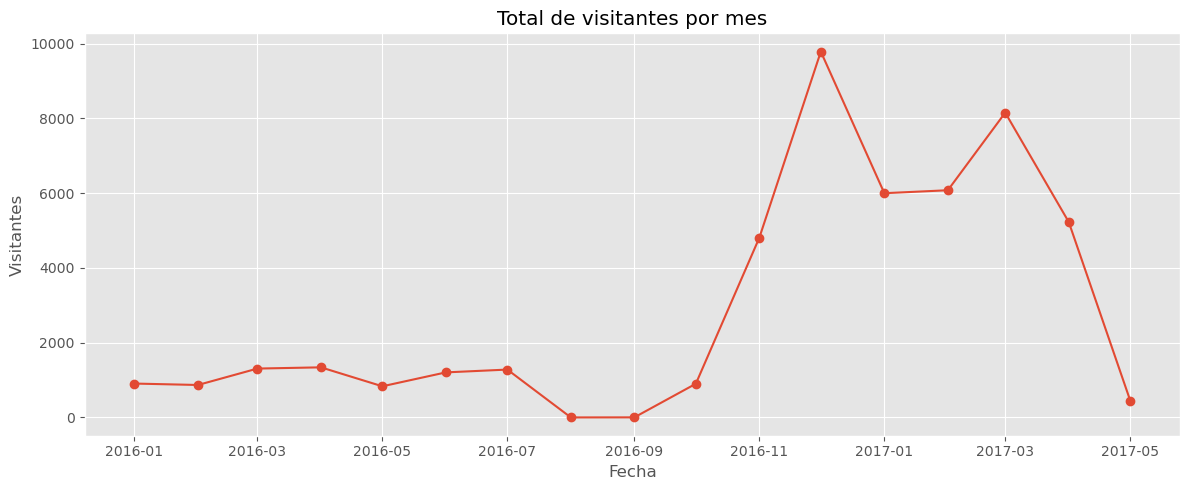

In [192]:
# Visualizando datos

plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
plt.plot(df_mes.index, df_mes['reserve_visitors'], marker='o', linestyle='-')
plt.title('Total de visitantes por mes')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede algunos factores importantes de las series de tiempo como que existe una tendencia positiva. Sin embargo, es es evidente que existe una gran disparidad entre los datos lo cuál levanta las sospechas de que hacer el forecasting con una agregación mensual no es lo más adecuado, pues existe mucha variación entre cada uno de los periodos.

In [193]:
# Separando por año y mes la varibale visit_date
df['Año'] = df['visit_date'].dt.year
df['Mes'] = df['visit_date'].dt.month

In [194]:
df_estacionalidad = df.pivot_table(index=['Mes'],columns=['Año'], values=['reserve_visitors'], aggfunc='sum')

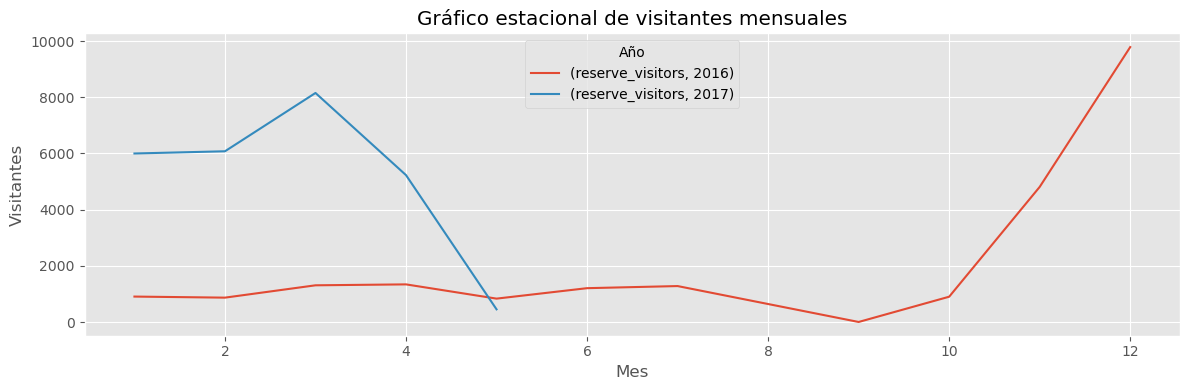

In [195]:
# Observando si existe estacionalidad con los datos que tenemos disponibles

df_estacionalidad.plot(figsize=(12, 4))
plt.style.use('ggplot')
plt.title('Gráfico estacional de visitantes mensuales')
plt.xlabel('Mes')
plt.ylabel('Visitantes')
plt.legend(title='Año')
plt.tight_layout()
plt.show()

En esta gráfica podemos observar que no hay forma de poder observar momentos estacionales a través del tiempo, pues solo tenemos un año y meido para poder hacer las comparaciones, por lo que no es funcional para poder hacer un forecasting adecuado.

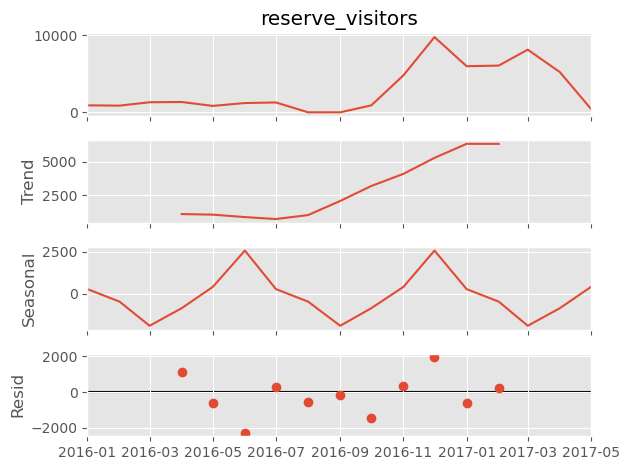

In [196]:
# Observando la descomposición estacional del df

decompose_result = seasonal_decompose(df_mes['reserve_visitors'], model='additive', period=6)
decompose_result.plot()
plt.tight_layout()
plt.show()

Dado que no tenemos 24 meses para ejecutar el modelo correctamente, se ocupan 17 meses, con lo que aún así podemos observar una tendecia positiva; sin embargo, al tener pocos datos en esta agregación los datos no son concluyentes.

In [197]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_mes['reserve_visitors'])

print('Resultado de la prueba Dickey-Fuller:')
print(f'Estadístico ADF       : {adf_result[0]:.4f}')
print(f'Valor p               : {adf_result[1]:.4f}')
print('Valores críticos:')
for key, value in adf_result[4].items():
    print(f'   {key} : {value:.4f}')


Resultado de la prueba Dickey-Fuller:
Estadístico ADF       : -0.1790
Valor p               : 0.9410
Valores críticos:
   1% : -4.3316
   5% : -3.2330
   10% : -2.7487


El p-valor es mucho mayor a 0.05, así que no se puede rechazar la hipótesis nula. Esto significa que la serie tiene una tendencia clara. Por lo que al no tener muestras significativas de los datos, buscaré la opción de pasar a una granularidad semanal para ver si es que podemos obtener mejores resultados y un forecast más preciso

### **Exploración de los datos a través del tiempo (Semanal)**

In [198]:
# Cambiando la frecuencia a nivel semanal

df['visit_date'] = pd.to_datetime(df['visit_date'])
df = df.set_index('visit_date')
df_weekly = df['reserve_visitors'].resample('W').sum()


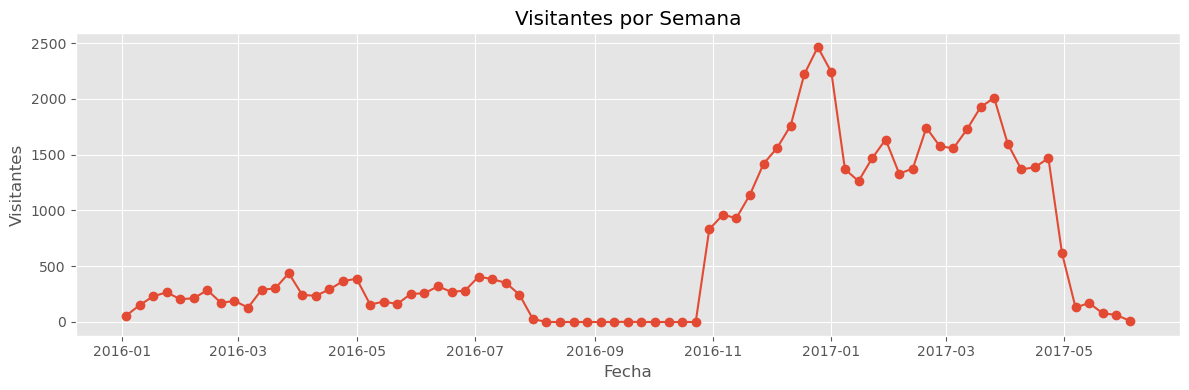

In [199]:
# Visualizando datos con frecuencia semanal

plt.figure(figsize=(12, 4))
plt.style.use('ggplot')
plt.plot(df_weekly, marker='o', linestyle='-')
plt.title('Visitantes por Semana')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.tight_layout()
plt.show()


En este punto, podemos observar que para los meses 2016-8 a 2016-11 existen datos que pudieran ser faltantes o que tuvieron bajo nivel de visitas, lo cual dificulta la tarea de realizar el forecast y tener datos precisos pues simplemente no existe una tendencia clara.

Lo que se hará a continuación será hacer un corte a la línea temporal para buscar mejorar la predicción.

In [229]:
# Se filtran fechas válidas después de un punto mínimo de actividad
df_weekly_clean = df_weekly[df_weekly.index >= '2016-11-01']
#df_weekly_clean = df_weekly


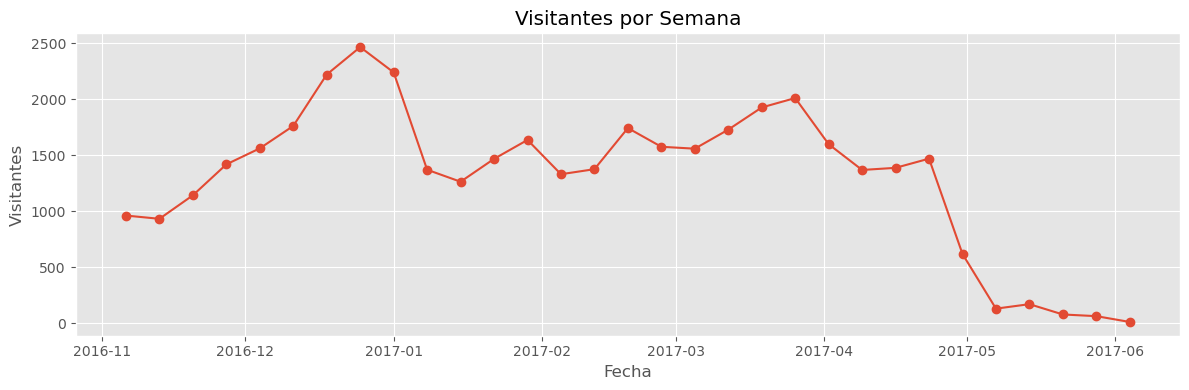

In [230]:
# Visualizando datos con la nueva frecuencia semanal 

plt.figure(figsize=(12, 4))
plt.style.use('ggplot')
plt.plot(df_weekly_clean, marker='o', linestyle='-')
plt.title('Visitantes por Semana')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.tight_layout()
plt.show()


In [231]:
df_weekly_clean = df_weekly_clean.to_frame(name='reserve_visitors')

In [232]:
adf_result_weekly = adfuller(df_weekly_clean['reserve_visitors'])
print('Prueba ADF para la serie semanal:')
print(f'Estadístico ADF       : {adf_result_weekly[0]:.4f}')
print(f'Valor p               : {adf_result_weekly[1]:.4f}')
print('Valores críticos:')
for key, value in adf_result_weekly[4].items():
    print(f'   {key} : {value:.4f}')


Prueba ADF para la serie semanal:
Estadístico ADF       : -0.3460
Valor p               : 0.9187
Valores críticos:
   1% : -3.6889
   5% : -2.9720
   10% : -2.6253


Se puede observar que existe un p-valor = 0.5399 lo cuál concluye que La serie no es estacionaria a nivel semanal. Necesitamos aplicar diferenciación para estabilizarla antes de ajustar un modelo.

In [233]:
df_weekly_diff = df_weekly_clean.diff().dropna()
adf_result_diff = adfuller(df_weekly_diff['reserve_visitors'])

print('Prueba ADF para la serie diferenciada:')
print(f'Estadístico ADF       : {adf_result_diff[0]:.4f}')
print(f'Valor p               : {adf_result_diff[1]:.4f}')
print('Valores críticos:')
for key, value in adf_result_diff[4].items():
    print(f'   {key} : {value:.4f}')


Prueba ADF para la serie diferenciada:
Estadístico ADF       : -4.4199
Valor p               : 0.0003
Valores críticos:
   1% : -3.6889
   5% : -2.9720
   10% : -2.6253


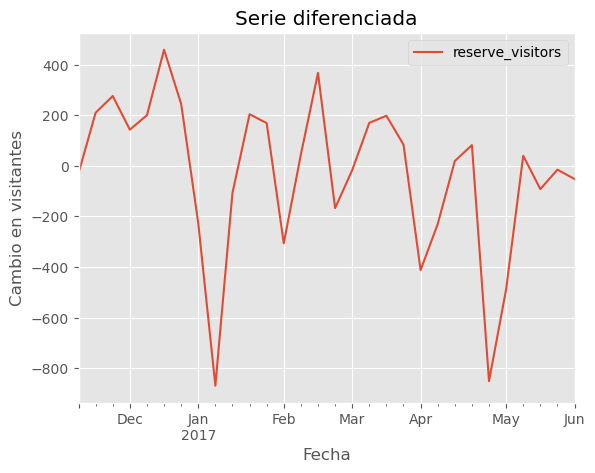

In [234]:
# Serie de tiempo con diferenciación

df_weekly_diff = df_weekly_clean.diff().dropna()
df_weekly_diff.plot()
plt.title('Serie diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Cambio en visitantes')
plt.show()

Con esto, pareciera ser que la serie de tiempo es más estable y pudieramos llegar a tener mejores predicciones.

## **Preparando forecast (ARMA)**

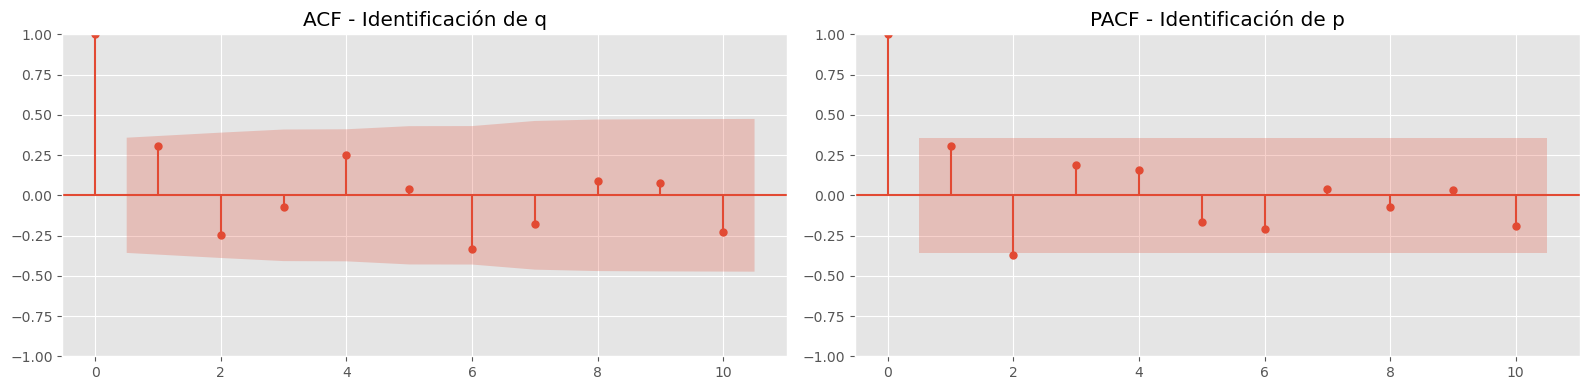

In [235]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_weekly_diff['reserve_visitors'], ax=axes[0], lags=10)
axes[0].set_title('ACF - Identificación de q')

plot_pacf(df_weekly_diff['reserve_visitors'], ax=axes[1], lags=10)
axes[1].set_title('PACF - Identificación de p')

plt.tight_layout()
plt.show()



In [236]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenado el modelo

modelo = ARIMA(df_weekly_clean['reserve_visitors'], order=(1, 1, 1))
modelo_entrenado = modelo.fit()
print(modelo_entrenado.summary())

                               SARIMAX Results                                
Dep. Variable:       reserve_visitors   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -211.643
Date:                Sun, 20 Jul 2025   AIC                            429.286
Time:                        22:19:24   BIC                            433.490
Sample:                    11-06-2016   HQIC                           430.631
                         - 06-04-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1210      0.555     -0.218      0.828      -1.210       0.967
ma.L1          0.5872      0.491      1.197      0.231      -0.375       1.549
sigma2      7.763e+04   1.43e+04      5.438      0.0

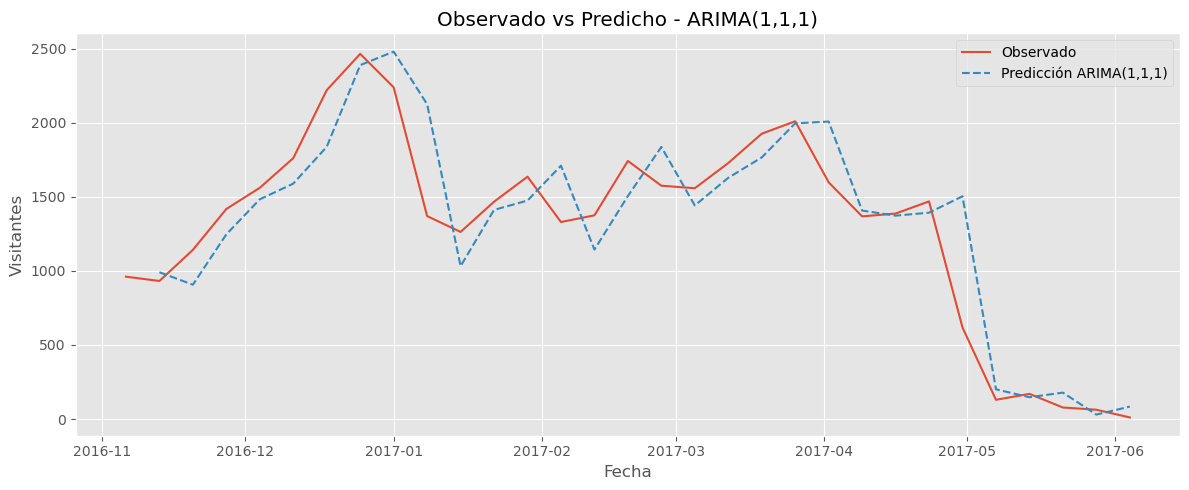

In [237]:
# Realizando las predicciones para evaluar el modelo

predicciones = modelo_entrenado.predict(start=1, end=len(df_weekly_clean)-1, typ='levels')
plt.figure(figsize=(12, 5))
plt.plot(df_weekly_clean.index, df_weekly_clean['reserve_visitors'], label='Observado')
plt.plot(df_weekly_clean.index[1:], predicciones, label='Predicción ARIMA(1,1,1)', linestyle='--')
plt.title('Observado vs Predicho - ARIMA(1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.legend()
plt.tight_layout()
plt.show()


In [238]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluando el modelo

y_true = df_weekly_clean['reserve_visitors'].iloc[1:]
y_pred = predicciones

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE  : {mae:.2f}')
print(f'RMSE : {rmse:.2f}')
print(f'MAPE : {mape:.2f}%')


MAE  : 194.72
RMSE : 279.28
MAPE : 45.36%


El modelo capta la tendencia general, pero la variabilidad semanal aún no la predice con tanta precisión, pues se observa que:

* MAE = 194.72: en promedio, el modelo se equivoca por 198 visitantes por semana.
* RMSE = 279.28: los errores grandes son penalizados más. Esto sugiere que algunos errores son más altos que el promedio.
* MAPE = 45.36%: el modelo tiene un error porcentual bastante alto, indicando que no es muy preciso (más del 20-30% ya se considera regular en muchos contextos).

Sin embargo, al no tener tantos datos significativos en nuestra base de datos, explorar otros métodos podría llegar a ser insignificante, por lo que tomaremos este modelo para poder predecir


### **Predicción**

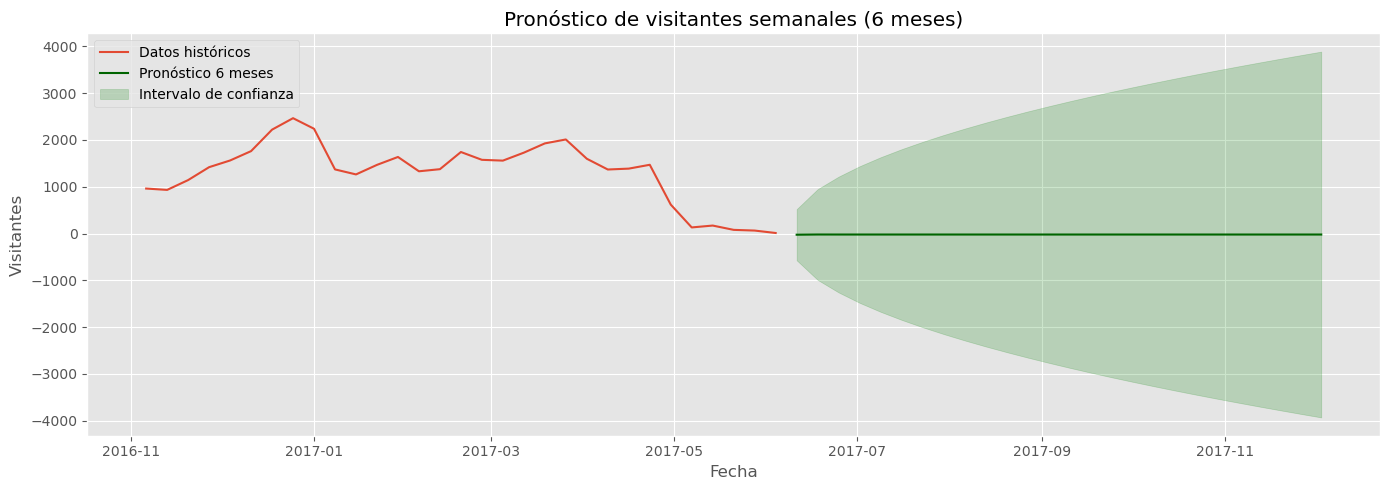

In [240]:
n_pred = 26

forecast = modelo_entrenado.get_forecast(steps=n_pred)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_date = df_weekly_clean.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_pred, freq='W-SUN')

forecast_mean.index = future_dates
forecast_ci.index = future_dates

plt.figure(figsize=(14, 5))
plt.plot(df_weekly_clean, label='Datos históricos')
plt.plot(forecast_mean, label='Pronóstico 6 meses', color='darkgreen')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='green', alpha=0.2, label='Intervalo de confianza')
plt.title('Pronóstico de visitantes semanales (6 meses)')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.legend()
plt.tight_layout()
plt.show()



In [243]:
forecast_mean[:5]

2017-06-11   -25.624262
2017-06-18   -21.192291
2017-06-25   -21.728612
2017-07-02   -21.663711
2017-07-09   -21.671565
Freq: W-SUN, Name: predicted_mean, dtype: float64

# **Conclusón:**

Después de revisar la serie mensual y ver que solo teníamos 17 observaciones, decidimos trabajar a nivel semanal para tener más datos y así mejorar el análisis. Agrupamos por semana y observamos que algunos periodos tenían valores cero, por lo que limpiamos esos datos antes de continuar.

Aplicamos la prueba ADF y confirmamos que la serie no era estacionaria, así que hicimos la primera diferencia. Con la serie ya diferenciada, la prueba ADF confirmó estacionariedad.

Luego analizamos la ACF y PACF para definir los parámetros p y q del modelo ARIMA. Entrenamos el modelo y lo evaluamos con los siguientes resultados:

* MAE: 194.72

* RMSE: 279.28

* MAPE: 45.36%

El MAPE sigue siendo alto, pero se debe a la baja escala de algunas semanas, lo cual afecta el porcentaje. Aun así, el modelo logra seguir bien el patrón general de la serie.

Finalmente, generamos el forecast para las siguientes 26 semanas (6 meses). Aunque el pronóstico muestra una tendencia estable, el intervalo de confianza se vuelve amplio hacia el futuro, lo que refleja la incertidumbre del modelo al no tener suficiente historial de largo plazo.

### **Siguientes pasos**

Recolectar más datos históricos
El modelo actual trabaja con 36 observaciones semanales, lo cual limita tanto su capacidad de aprendizaje como la precisión del pronóstico a largo plazo. Al tener menos de un año completo de datos, es difícil capturar patrones estacionales reales, lo que también afecta la estabilidad de los intervalos de confianza en el forecast.

* Contar con al menos dos años de datos semanales (alrededor de 100 observaciones) permitiría:

* Capturar patrones anuales reales, si existen.

* Mejorar la identificación de estacionalidades semanales, mensuales o relacionadas a periodos festivos.

* Reducir la varianza del modelo y dar mayor confianza en las predicciones.

* Evaluar la evolución del comportamiento de los visitantes a lo largo del tiempo y anticipar cambios de tendencia.

Acción recomendada: solicitar acceso a registros anteriores (si existen) o implementar un sistema automático de captura semanal para mantener un histórico sólido y actualizado.